In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings                   
warnings.filterwarnings('ignore')

In [2]:
# Read the preprocessed dataset
df = pd.read_csv("Penrose_Data_TopFeatures_R1.csv")

# Display few rows
df

,Unnamed: 0,PM10_RollingMean3,PM10_RollingStd3,PM10_Lag1,PM10_Lag2,PM10_Lag3,AC Penrose PM10 1h average [µg/m³],Datetime
0,3,21.313667,3.065331,24.846,19.352,19.518,19.743,2014-06-01 04:00:00
1,4,20.489000,4.036043,19.743,24.846,19.352,16.878,2014-06-01 05:00:00
2,5,16.957333,2.746859,16.878,19.743,24.846,14.251,2014-06-01 06:00:00
3,6,15.264000,1.412863,14.251,16.878,19.743,14.663,2014-06-01 07:00:00
4,7,12.133667,4.029401,14.663,14.251,16.878,7.487,2014-06-01 08:00:00
...,...,...,...,...,...,...,...,...
80492,80495,11.589000,3.838068,7.300,14.700,5.900,12.767,2023-12-30 19:00:00
80493,80496,11.978000,4.337656,12.767,7.300,14.700,15.867,2023-12-30 20:00:00
80494,80497,15.411333,2.448509,15.867,12.767,7.300,17.600,2023-12-30 21:00:00
80495,80498,13.075667,6.394533,17.600,15.867,12.767,5.760,2023-12-30 22:00:00


In [3]:
#set datetime as index
df = df.set_index("Datetime")

#drop unwanted column
df = df.drop("Unnamed: 0", axis=1)

#check null values
df.isnull().sum()

PM10_RollingMean3                     0
PM10_RollingStd3                      0
PM10_Lag1                             0
PM10_Lag2                             0
PM10_Lag3                             0
AC Penrose PM10 1h average [µg/m³]    0
dtype: int64

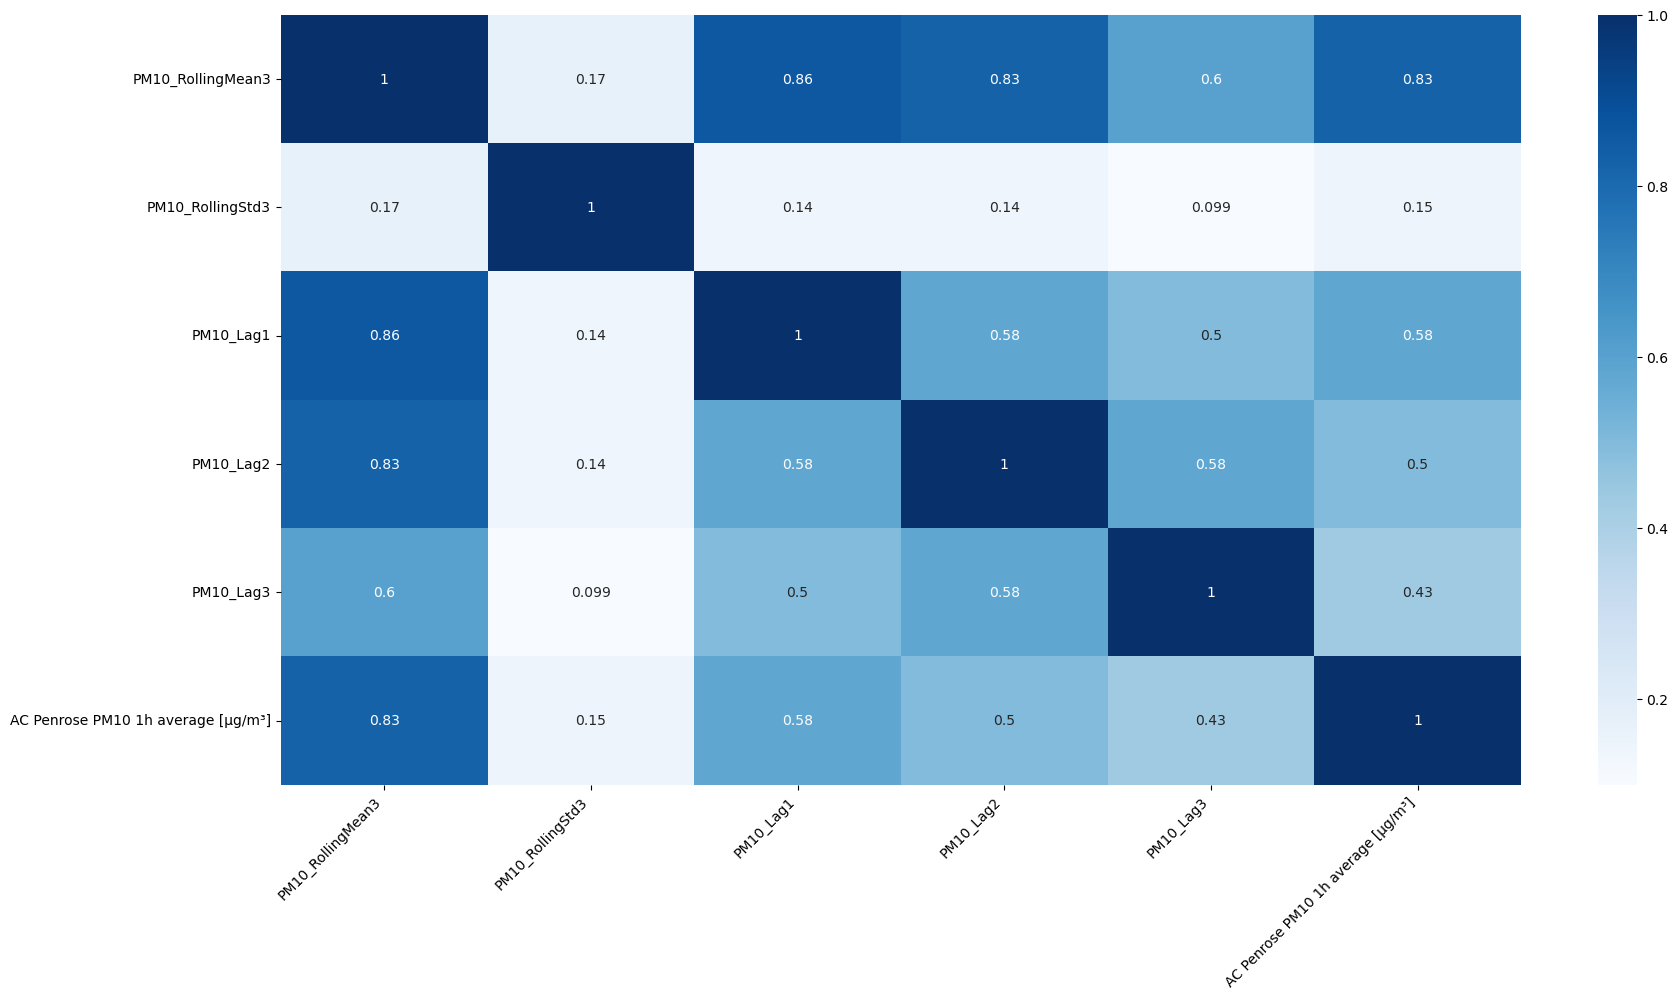

In [4]:
#Visualizing Feature Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(df.corr(), cmap= "Blues", annot=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [5]:
#drop high correlated features column "NOX"
#df = df.drop("NOX_MCG 1h average", axis=1)

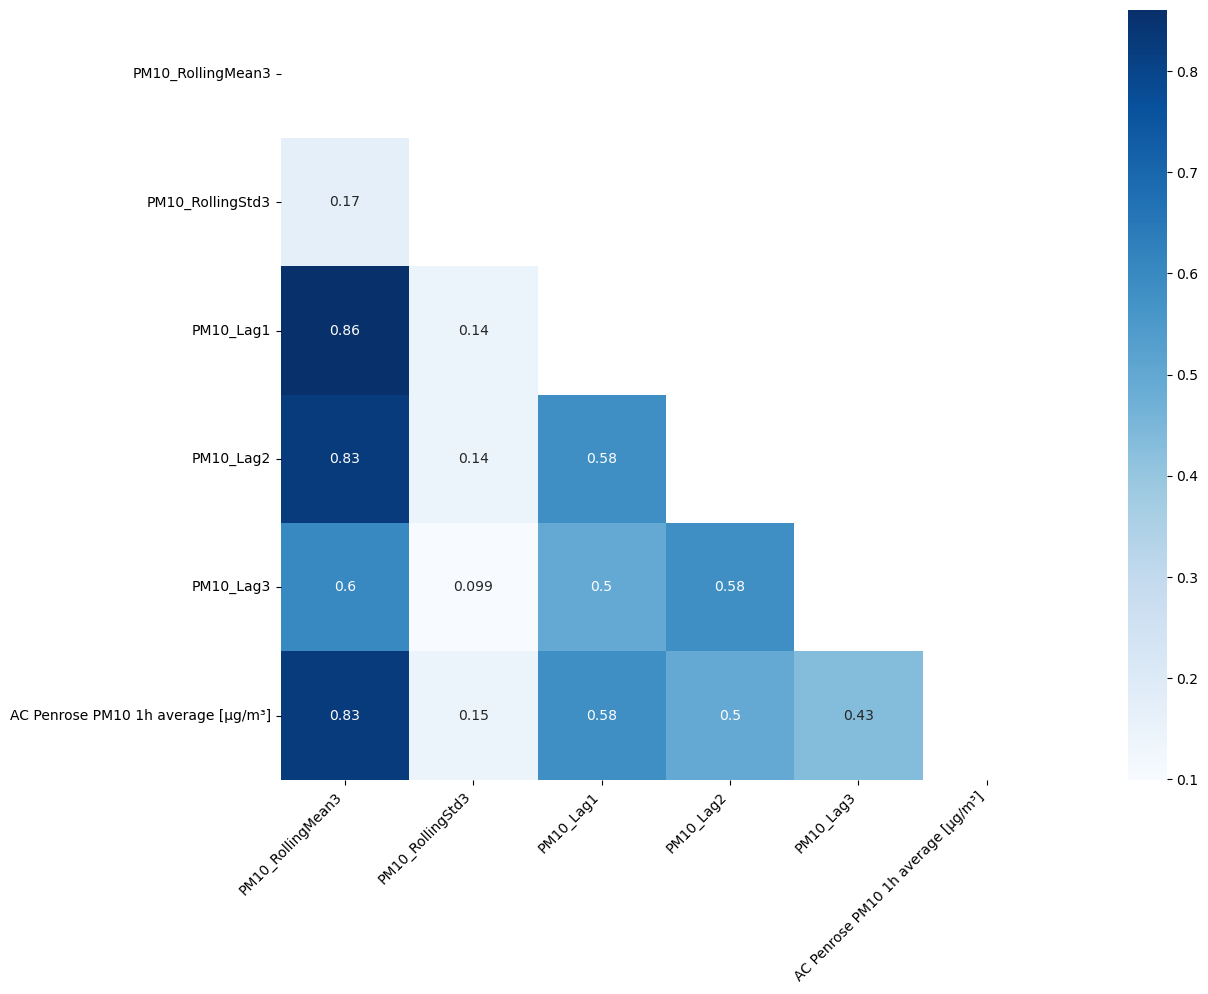

In [6]:
# Calculate the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap="Blues", annot=True, square=True)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

### XGBoost

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle
import pandas as pd

# Split supporting features (X) and target feature (y)
X = df.drop('AC Penrose PM10 1h average [µg/m³]', axis=1)
y = df["AC Penrose PM10 1h average [µg/m³]"]

# Including validation
X_train, y_train = X[:64000], y[:64000]
X_test, y_test = X[64000:], y[64000:]

# Define the parameter grid
param_grid = {
    'alpha': [0, 0.1, 0.5, 1],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'lambda': [0, 0.1, 0.5],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor()

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Initialize the best XGBoost Regressor with the best parameters
best_xgb = xgb.XGBRegressor(**best_params)

# Fit the model
best_xgb.fit(X_train, y_train)

# Predict on training set
y_train_pred = best_xgb.predict(X_train)

# Predict on test set
y_test_pred = best_xgb.predict(X_test)

# Calculate R2 score for training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R2 score on training set: {r2_train:.4f}")

# Calculate R2 score for test set
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 score on test set: {r2_test:.4f}")

# Evaluate the model
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Root Mean Squared Error (RMSE) on test set: {rmse:.4f}")

# Save the best XGBoost model
pickle.dump(best_xgb, open("best_xgb_model2.pkl", "wb"))


Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
Best parameters found: {'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 0, 'learning_rate': 0.05, 'max_depth': 9, 'subsample': 0.8}
R2 score on training set: 0.9992
R2 score on test set: 0.9982
Root Mean Squared Error (RMSE) on test set: 0.3117


                     Actual  Predicted
2021-01-01 00:00:00   7.400   7.447202
2021-01-01 01:00:00   5.300   5.205922
2021-01-01 02:00:00   2.367   2.732210
2021-01-01 03:00:00   9.983  10.141545
2021-01-01 04:00:00   4.083   3.950181


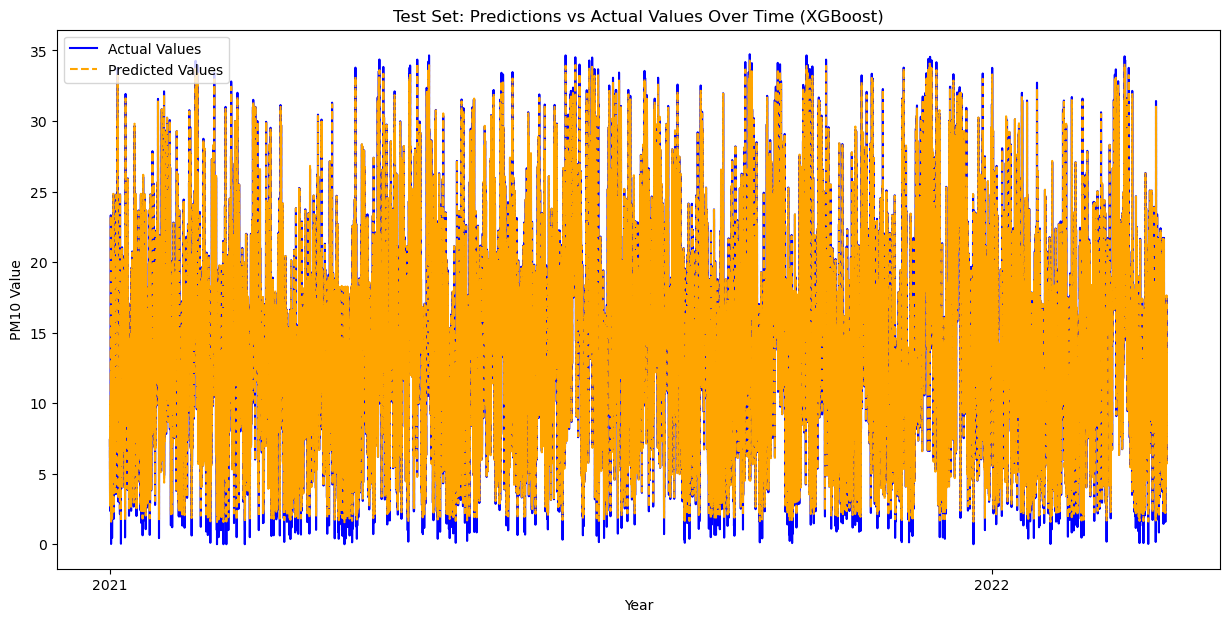

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure y_test and y_test_pred are 1-dimensional
y_test_flat = y_test.ravel() if len(y_test.shape) > 1 else y_test
y_test_pred_flat = y_test_pred.ravel() if len(y_test_pred.shape) > 1 else y_test_pred

# Create a DataFrame to hold actual and predicted values for the test set
results_xgb = pd.DataFrame({
    'Actual': y_test_flat,
    'Predicted': y_test_pred_flat
}, index=pd.date_range(start='2021-01-01', periods=len(y_test_flat), freq='H'))

# Check the first few rows of the DataFrame to ensure it is correctly populated
print(results_xgb.head())

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(results_xgb.index, results_xgb['Actual'], label='Actual Values', color='blue')
plt.plot(results_xgb.index, results_xgb['Predicted'], label='Predicted Values', color='orange', linestyle='--')
plt.title('Test Set: Predictions vs Actual Values Over Time (XGBoost)')
plt.xlabel('Year')
plt.ylabel('PM10 Value')
plt.legend()

# Change x-axis to show only the years
years = pd.date_range(start=results_xgb.index.min(), end=results_xgb.index.max(), freq='YS').year
plt.gca().set_xticks([pd.Timestamp(f'{year}-01-01') for year in years])
plt.gca().set_xticklabels([str(year) for year in years])

plt.show()


### Random Forest

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle

# Split depending features (X) and target feature (y)
X = df.drop('AC Penrose PM10 1h average [µg/m³]', axis=1)
y = df['AC Penrose PM10 1h average [µg/m³]']

# Split the data into training and testing sets
X_train, X_test = X[:64000], X[64000:]
y_train, y_test = y[:64000], y[64000:]

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Initialize RandomForestRegressor with best parameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)

# Train the model with the best parameters
best_rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = best_rf_model.predict(X_train)

# Make predictions on the test set
y_test_pred = best_rf_model.predict(X_test)

# Evaluate the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Mean Squared Error: {train_mse}')
print(f'Training R^2 Score: {train_r2}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R^2 Score: {test_r2}')

# Save the best Random Forest model
with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(best_rf_model, f)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Mean Squared Error: 0.025980000829910633
Training R^2 Score: 0.9994778149593723
Test Mean Squared Error: 0.24968101522747685
Test R^2 Score: 0.9952608648610646


                     Actual  Predicted
2021-01-01 00:00:00   7.400   7.447202
2021-01-01 01:00:00   5.300   5.205922
2021-01-01 02:00:00   2.367   2.732210
2021-01-01 03:00:00   9.983  10.141545
2021-01-01 04:00:00   4.083   3.950181


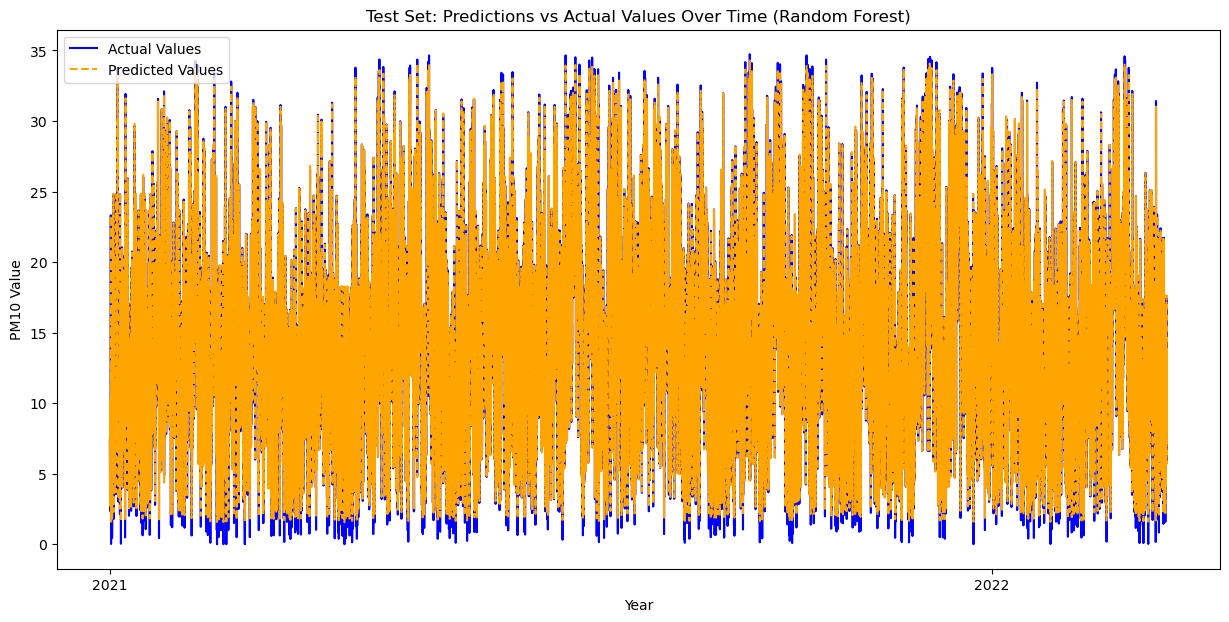

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test and y_test_pred are available from the Random Forest model
# Create a DataFrame to hold actual and predicted values for the test set
results_rf = pd.DataFrame({
    'Actual': y_test.ravel() if len(y_test.shape) > 1 else y_test,
    'Predicted': y_test_pred.ravel() if len(y_test_pred.shape) > 1 else y_test_pred
}, index=pd.date_range(start='2021-01-01', periods=len(y_test), freq='H'))

# Check the first few rows of the DataFrame to ensure it is correctly populated
print(results_rf.head())

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(results_rf.index, results_rf['Actual'], label='Actual Values', color='blue')
plt.plot(results_rf.index, results_rf['Predicted'], label='Predicted Values', color='orange', linestyle='--')
plt.title('Test Set: Predictions vs Actual Values Over Time (Random Forest)')
plt.xlabel('Year')
plt.ylabel('PM10 Value')
plt.legend()

# Change x-axis to show only the years
years = pd.date_range(start=results_rf.index.min(), end=results_rf.index.max(), freq='YS').year
plt.gca().set_xticks([pd.Timestamp(f'{year}-01-01') for year in years])
plt.gca().set_xticklabels([str(year) for year in years])

plt.show()


### SVM

In [11]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Split dependent features (X) and target feature (y)
X = df.drop('AC Penrose PM10 1h average [µg/m³]', axis=1)
y = df['AC Penrose PM10 1h average [µg/m³]']

# Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, y_train = X_scaled[:64000], y_scaled[:64000]
X_test, y_test = X_scaled[64000:], y_scaled[64000:]

# Define the parameter grid for SVR
param_distributions = {
    'C': [1, 10],
    'gamma': [0.1, 0.01],
    'epsilon': [0.1, 0.01]
}

# Initialize Support Vector Regressor
svm_model = SVR(kernel='rbf')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_distributions,
                                   cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Get the best parameters from the RandomizedSearchCV
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

# Train the model with the best parameters
best_svm_model = random_search.best_estimator_

# Make predictions on the training set
y_train_pred = best_svm_model.predict(X_train)

# Make predictions on the test set
y_test_pred = best_svm_model.predict(X_test)

# Inverse transform predictions to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Mean Squared Error: {train_mse}')
print(f'Training R^2 Score: {train_r2}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R^2 Score: {test_r2}')

# Save the SVM best model
pickle.dump(best_svm_model, open("best_svm_model.pkl", "wb"))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found: {'gamma': 0.01, 'epsilon': 0.01, 'C': 10}
Training Mean Squared Error: 0.0008328501721246766
Training R^2 Score: 0.9999832601275183
Test Mean Squared Error: 0.000958243518910383
Test R^2 Score: 0.99998181181085


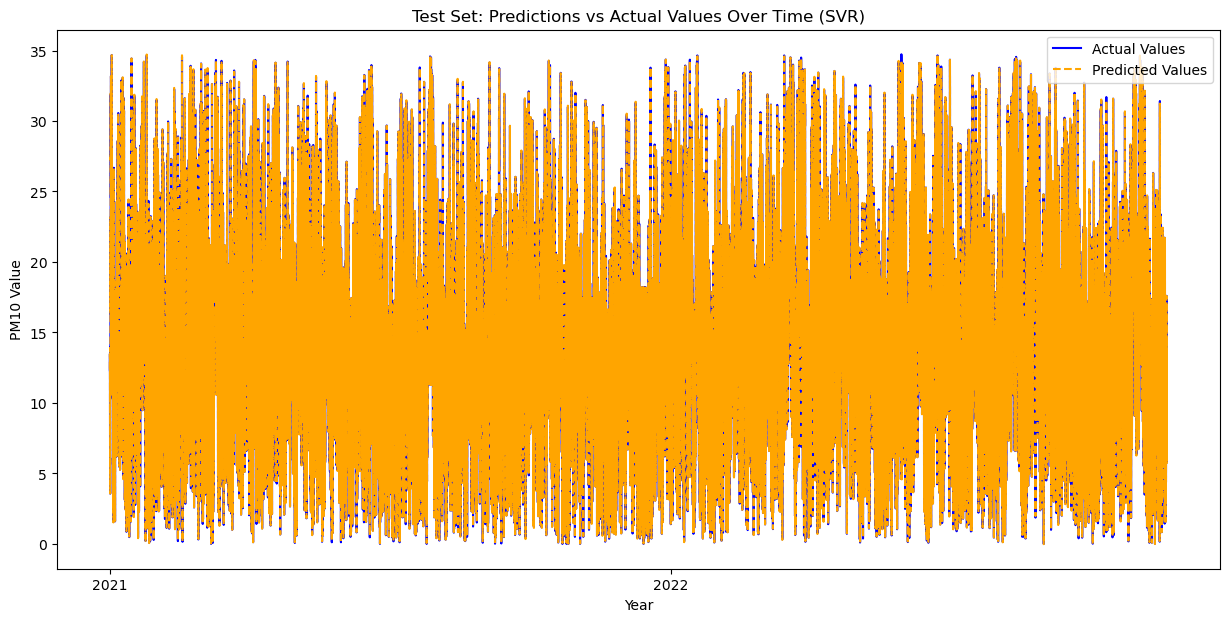

In [12]:
# Assuming y_test and y_test_pred are available from the SVR model
# Create a DataFrame to hold actual and predicted values for the test set
results_svr = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
}, index=pd.date_range(start='2021-01-01', periods=len(y_test), freq='H'))

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(results_svr.index, results_svr['Actual'], label='Actual Values', color='blue')
plt.plot(results_svr.index, results_svr['Predicted'], label='Predicted Values', color='orange', linestyle='--')
plt.title('Test Set: Predictions vs Actual Values Over Time (SVR)')
plt.xlabel('Year')
plt.ylabel('PM10 Value')
plt.legend()

# Change x-axis to show only the years
years = pd.date_range(start=results_svr.index.min(), end=results_svr.index.max(), freq='YS').year
plt.gca().set_xticks([pd.Timestamp(f'{year}-01-01') for year in years])
plt.gca().set_xticklabels([str(year) for year in years])

plt.show()


### GRU

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Split depending features (X) and target feature (y)
X = df.drop('AC Penrose PM10 1h average [µg/m³]', axis=1).values
y = df['AC Penrose PM10 1h average [µg/m³]'].values

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training, validation, and testing sets
X_train, y_train = X_scaled[:60000], y_scaled[:60000]
X_val, y_val = X_scaled[60000:70000], y_scaled[60000:70000]
X_test, y_test = X_scaled[70000:], y_scaled[70000:]

# Reshape data for GRU model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the GRU model
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=64, verbose=2, callbacks=[early_stopping, reduce_lr])

# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_val_pred = scaler_y.inverse_transform(y_val_pred)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Inverse transform true values
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Mean Squared Error: {train_mse}')
print(f'Training R^2 Score: {train_r2}')
print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R^2 Score: {test_r2}')

# Save the best GRU model
model.save("gru_model.h5")

Epoch 1/50
938/938 - 7s - 7ms/step - loss: 0.0117 - val_loss: 4.6472e-05 - learning_rate: 0.0010
Epoch 2/50
938/938 - 4s - 4ms/step - loss: 2.7718e-05 - val_loss: 2.4781e-05 - learning_rate: 0.0010
Epoch 3/50
938/938 - 3s - 3ms/step - loss: 1.8032e-05 - val_loss: 1.6990e-05 - learning_rate: 0.0010
Epoch 4/50
938/938 - 5s - 5ms/step - loss: 1.4066e-05 - val_loss: 3.2176e-05 - learning_rate: 0.0010
Epoch 5/50
938/938 - 3s - 3ms/step - loss: 1.1424e-05 - val_loss: 9.6519e-06 - learning_rate: 0.0010
Epoch 6/50
938/938 - 5s - 5ms/step - loss: 9.3437e-06 - val_loss: 1.5179e-05 - learning_rate: 0.0010
Epoch 7/50
938/938 - 3s - 3ms/step - loss: 5.9561e-06 - val_loss: 6.6478e-06 - learning_rate: 2.0000e-04
Epoch 8/50
938/938 - 3s - 3ms/step - loss: 5.5494e-06 - val_loss: 6.0470e-06 - learning_rate: 2.0000e-04
Epoch 9/50
938/938 - 3s - 3ms/step - loss: 5.1388e-06 - val_loss: 6.0531e-06 - learning_rate: 2.0000e-04
Epoch 10/50
938/938 - 5s - 5ms/step - loss: 4.5521e-06 - val_loss: 5.1168e-06 - lea


Training R^2 Score: 0.9999904989358227
Validation Mean Squared Error: 0.0006255087981909268
Validation R^2 Score: 0.9999882498504337
Test Mean Squared Error: 0.0006406036023528108
Test R^2 Score: 0.9999878226695643


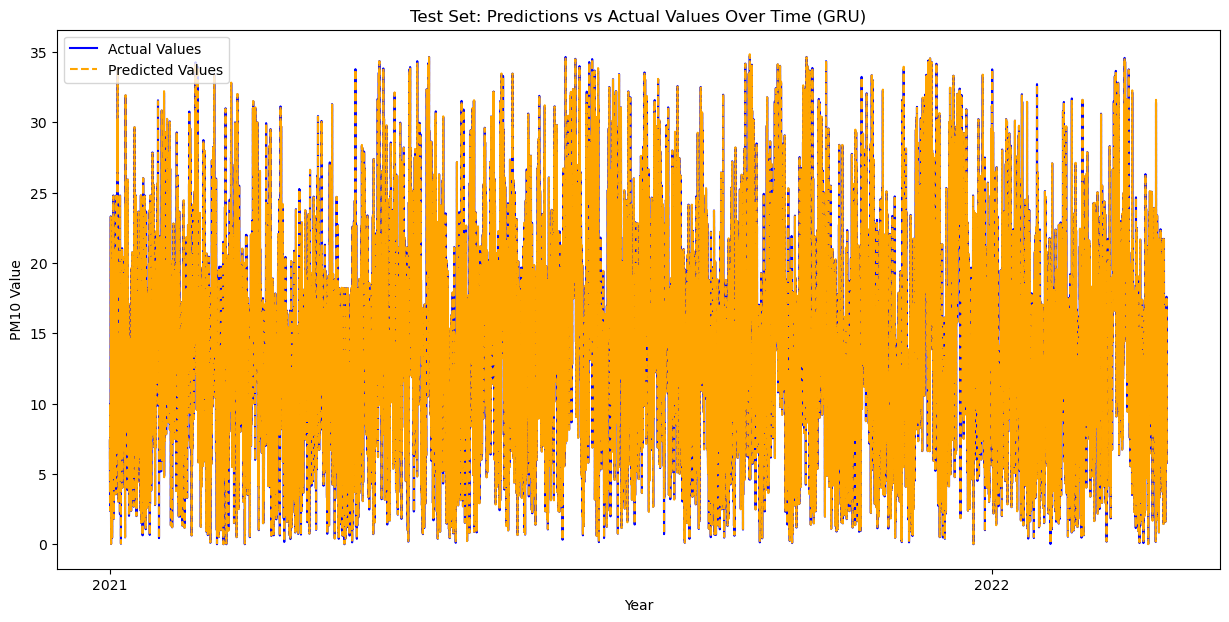

In [14]:
# Assuming y_test and y_test_pred are available from the GRU model
# Create a DataFrame to hold actual and predicted values for the test set
results_gru = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
}, index=pd.date_range(start='2021-01-01', periods=len(y_test), freq='H'))

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(results_gru.index, results_gru['Actual'], label='Actual Values', color='blue')
plt.plot(results_gru.index, results_gru['Predicted'], label='Predicted Values', color='orange', linestyle='--')
plt.title('Test Set: Predictions vs Actual Values Over Time (GRU)')
plt.xlabel('Year')
plt.ylabel('PM10 Value')
plt.legend()

# Change x-axis to show only the years
years = pd.date_range(start=results_gru.index.min(), end=results_gru.index.max(), freq='YS').year
plt.gca().set_xticks([pd.Timestamp(f'{year}-01-01') for year in years])
plt.gca().set_xticklabels([str(year) for year in years])

plt.show()


### LSTM

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Split depending features (X) and target feature (y)
X = df.drop('AC Penrose PM10 1h average [µg/m³]', axis=1).values
y = df['AC Penrose PM10 1h average [µg/m³]'].values

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training, validation, and testing sets
X_train, y_train = X_scaled[:60000], y_scaled[:60000]
X_val, y_val = X_scaled[60000:70000], y_scaled[60000:70000]
X_test, y_test = X_scaled[70000:], y_scaled[70000:]

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model with multiple layers and dropout
model = Sequential([
    LSTM(units=100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(units=100, activation='relu'),
    Dropout(0.3),
    Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=64, verbose=2, callbacks=[early_stopping, reduce_lr])

# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_val_pred = scaler_y.inverse_transform(y_val_pred)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Inverse transform true values
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Mean Squared Error: {train_mse}')
print(f'Training R^2 Score: {train_r2}')
print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R^2 Score: {test_r2}')

# Save the best LSTM model
model.save("lstm_model.keras")

Epoch 1/100
938/938 - 13s - 14ms/step - loss: 0.0599 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/100
938/938 - 10s - 10ms/step - loss: 0.0039 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/100
938/938 - 11s - 11ms/step - loss: 0.0029 - val_loss: 8.9593e-04 - learning_rate: 0.0010
Epoch 4/100
938/938 - 10s - 11ms/step - loss: 0.0024 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/100
938/938 - 11s - 11ms/step - loss: 0.0021 - val_loss: 6.7703e-04 - learning_rate: 0.0010
Epoch 6/100
938/938 - 5s - 6ms/step - loss: 0.0019 - val_loss: 5.4694e-04 - learning_rate: 0.0010
Epoch 7/100
938/938 - 10s - 11ms/step - loss: 0.0017 - val_loss: 6.7173e-04 - learning_rate: 0.0010
Epoch 8/100
938/938 - 10s - 11ms/step - loss: 0.0016 - val_loss: 4.6335e-04 - learning_rate: 0.0010
Epoch 9/100
938/938 - 5s - 5ms/step - loss: 0.0014 - val_loss: 6.8853e-04 - learning_rate: 0.0010
Epoch 10/100
938/938 - 5s - 6ms/step - loss: 0.0013 - val_loss: 7.2522e-04 - learning_rate: 0.0010
Epoch 11/100
938/

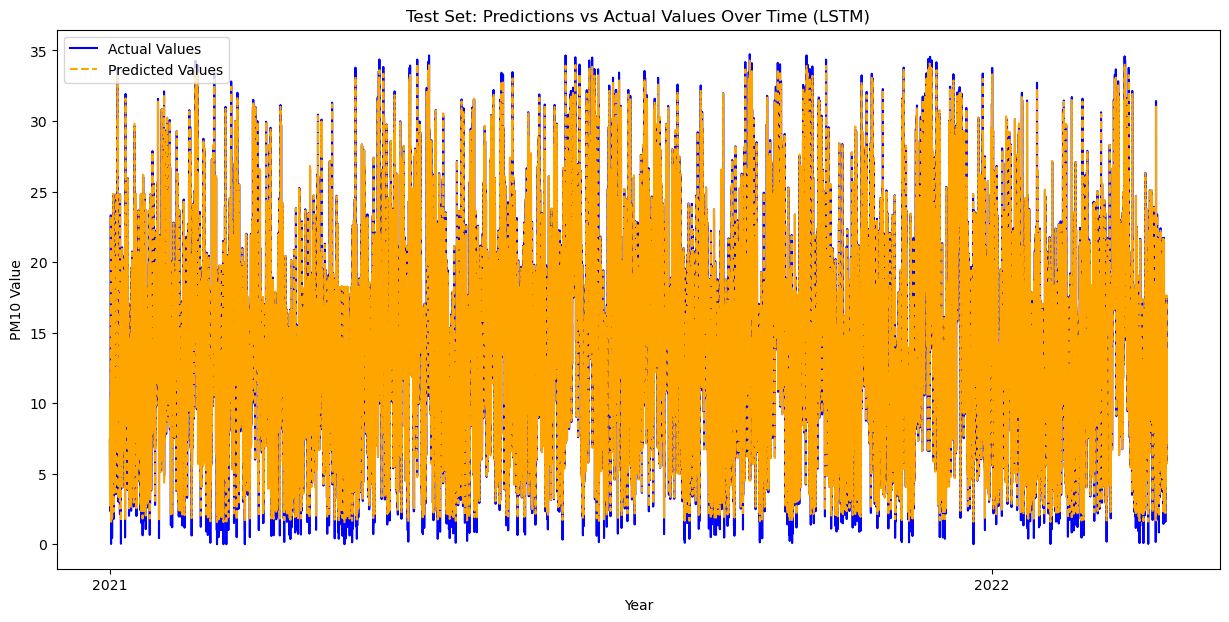

In [17]:
import matplotlib.pyplot as plt

# Create a DataFrame to hold actual and predicted values for the test set
results_test = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': y_test_pred.flatten()
}, index=pd.date_range(start='2021-01-01', periods=len(y_test), freq='H'))  # Assuming the test set starts from '2021-01-01'

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(results_test.index, results_test['Actual'], label='Actual Values', color='blue')
plt.plot(results_test.index, results_test['Predicted'], label='Predicted Values', color='orange', linestyle='--')
plt.title('Test Set: Predictions vs Actual Values Over Time (LSTM)')
plt.xlabel('Year')
plt.ylabel('PM10 Value')
plt.legend()

# Change x-axis to show only the years without specific dates
years = pd.date_range(start=results_test.index.min(), end=results_test.index.max(), freq='YS').year
plt.gca().set_xticks([pd.Timestamp(f'{year}-01-01') for year in years])
plt.gca().set_xticklabels([str(year) for year in years])

plt.show()
